In [41]:
import numpy as np
import pandas as pd

pd.set_option('max_columns', 200)
pd.options.display.max_rows = 250

import pandas_profiling as pp
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import math, string, os

In [2]:
train_df = pd.read_csv('train.csv', low_memory = False)

In [4]:
def Offense(row):
    if row["Team"] == "home":
        if row["HomeTeamAbbr"] == row["PossessionTeam"]:
            return 1
        else:
            return 0
    elif row["Team"] == "away":
        if row["VisitorTeamAbbr"] == row["PossessionTeam"]:
            return 1
        else:
            return 0

train_df["Offense"] = train_df.apply(lambda row: Offense(row), axis=1)

In [5]:
def Home(row):
    if row["Team"] == "home":
        return 1
    else:
        return 0

train_df["Home"] = train_df.apply(lambda row: Home(row), axis=1)

In [6]:
def Rusher(row):
    if row["NflId"] == row['NflIdRusher']:
        return 1
    else:
        return 0
    
train_df["Rusher"] = train_df.apply(lambda row: Rusher(row), axis = 1)

In [7]:
def DefenseTeam(row):
    if row["PossessionTeam"] == row["HomeTeamAbbr"]:
        return row["VisitorTeamAbbr"]
    else:
        return row["HomeTeamAbbr"]
    
train_df["DefenseTeam"] = train_df.apply(lambda row: DefenseTeam(row), axis = 1)

In [8]:
def EZDist(row):
    if row["PossessionTeam"] == row["FieldPosition"]:
        return (100 - row["YardLine"])
    else:
        return row["YardLine"]

train_df["EZDist"] = train_df.apply(lambda row: EZDist(row), axis = 1)

In [9]:
def OffPtDif(row):
    if row["PossessionTeam"] == row["HomeTeamAbbr"]:
        return row["HomeScoreBeforePlay"] - row["VisitorScoreBeforePlay"]
    else:
        return row["VisitorScoreBeforePlay"] - row["HomeScoreBeforePlay"]

train_df["OffPtDif"] = train_df.apply(lambda row: OffPtDif(row), axis = 1)

In [10]:
def OffHome(row):
    if row["PossessionTeam"] == row["HomeTeamAbbr"]:
        return 1
    else:
        return 0
train_df["OffHome"] = train_df.apply(lambda row: OffHome(row), axis = 1)

In [11]:
def group_game_weather(weather):
    rain = [
        'Rainy', 'Showers', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Rain'
    ]
    overcast = [
        'Rain Chance 40%', 'Party Cloudy', 'Cloudy, chance of rain', 'Rain likely, temps in low 40s.','Light Rain', 
        'Coudy', 'Cloudy, 50% change of rain', 
        'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
        'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
        'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
        'Partly Cloudy', 'Cloudy'
    ]
    clear = [
        'Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
        'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
        'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
        'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
        'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
        'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny'
    ]
    snow  = ['Heavy lake effect snow', 'Snow', 'Cloudy, light snow accumulating 1-3"']
    none  = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']
    
    if weather in rain:
        return 0
    elif weather in overcast:
        return 0
    elif weather in clear:
        return 0
    elif weather in snow:
        return 1
    elif weather in none:
        return 0
    return 0
    
train_df['GameWeather'] = train_df['GameWeather'].apply(group_game_weather)

In [12]:
def group_stadium_types(stadium):
    outdoor       = [
        'Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 
        'Outdor', 'Ourdoor', 'Outside', 'Outddors', 
        'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl', 'Outddors'
    ]
    indoor_closed = [
        'Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed', 
        'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed',
    ]
    indoor_open   = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']
    dome_closed   = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
    dome_open     = ['Domed, Open', 'Domed, open']
    
    if stadium in outdoor:
        return 1
    elif stadium in indoor_closed:
        return 0
    elif stadium in indoor_open:
        return 0
    elif stadium in dome_closed:
        return 0
    elif stadium in dome_open:
        return 0
    else:
        return 1
    
train_df['StadiumType'] = train_df['StadiumType'].apply(group_stadium_types)

In [13]:
def clean_wind_speed(windspeed):
   
    ws = str(windspeed)

    if ws.isdigit():
        return int(ws)

    if '-' in ws:
        return int(ws.split('-')[0])

    if ws.split(' ')[0].isdigit():
        return int(ws.split(' ')[0])

    if 'mph' in ws.lower():
        return int(ws.lower().split('mph')[0])
    else:
        return 0
    
train_df['WindSpeed'] = train_df['WindSpeed'].apply(clean_wind_speed)

In [14]:
def clean_wind_direction(wind_direction):
    wd = str(wind_direction).upper()
    if wd == 'N' or 'FROM S' in wd:
        return 'north'
    if wd == 'S' or 'FROM N' in wd:
        return 'south'
    if wd == 'W' or 'FROM E' in wd:
        return 'west'
    if wd == 'E' or 'FROM W' in wd:
        return 'east'
    
    if 'FROM SW' in wd or 'FROM SSW' in wd or 'FROM WSW' in wd:
        return 'north east'
    if 'FROM SE' in wd or 'FROM SSE' in wd or 'FROM ESE' in wd:
        return 'north west'
    if 'FROM NW' in wd or 'FROM NNW' in wd or 'FROM WNW' in wd:
        return 'south east'
    if 'FROM NE' in wd or 'FROM NNE' in wd or 'FROM ENE' in wd:
        return 'south west'
    
    if 'NW' in wd or 'NORTHWEST' in wd:
        return 'north west'
    if 'NE' in wd or 'NORTH EAST' in wd:
        return 'north east'
    if 'SW' in wd or 'SOUTHWEST' in wd:
        return 'south west'
    if 'SE' in wd or 'SOUTHEAST' in wd:
        return 'south east'

    return 'none'
train_df['WindDirection'] = train_df['WindDirection'].apply(clean_wind_direction)

In [15]:
train_df.loc[train_df['PossessionTeam'] == 'ARZ', 'PossessionTeam'] = 'ARI'
train_df.loc[train_df['PossessionTeam'] == 'BLT', 'PossessionTeam'] = 'BAL'
train_df.loc[train_df['PossessionTeam'] == 'CLV', 'PossessionTeam'] = 'CLE'
train_df.loc[train_df['PossessionTeam'] == 'HST', 'PossessionTeam'] = 'HOU'

train_df.loc[train_df['FieldPosition'] == 'ARZ', 'FieldPosition'] = 'ARI'
train_df.loc[train_df['FieldPosition'] == 'BLT', 'FieldPosition'] = 'BAL'
train_df.loc[train_df['FieldPosition'] == 'CLV', 'FieldPosition'] = 'CLE'
train_df.loc[train_df['FieldPosition'] == 'HST', 'FieldPosition'] = 'HOU'

In [38]:
train_df.loc[train_df['Position'] == 'SAF', 'Position'] = 'DB'
train_df.loc[train_df['Position'] == 'FS', 'Position'] = 'DB'
train_df.loc[train_df['Position'] == 'SAF', 'Position'] = 'DB'
train_df.loc[train_df['Position'] == 'SS', 'Position'] = 'DB'
train_df.loc[train_df['Position'] == 'CB', 'Position'] = 'DB'
train_df.loc[train_df['Position'] == 'S', 'Position'] = 'DB'

train_df.loc[train_df['Position'] == 'G', 'Position'] = 'OL'
train_df.loc[train_df['Position'] == 'C', 'Position'] = 'OL'
train_df.loc[train_df['Position'] == 'T', 'Position'] = 'OL'
train_df.loc[train_df['Position'] == 'OT', 'Position'] = 'OL'
train_df.loc[train_df['Position'] == 'OG', 'Position'] = 'OL'

train_df.loc[train_df['Position'] == 'DE', 'Position'] = 'DL'
train_df.loc[train_df['Position'] == 'DT', 'Position'] = 'DL'
train_df.loc[train_df['Position'] == 'NT', 'Position'] = 'DL'

train_df.loc[train_df['Position'] == 'OLB', 'Position'] = 'LB'
train_df.loc[train_df['Position'] == 'ILB', 'Position'] = 'LB'
train_df.loc[train_df['Position'] == 'MLB', 'Position'] = 'LB'

train_df.loc[train_df['Position'] == 'FB', 'Position'] = 'RB'
train_df.loc[train_df['Position'] == 'HB', 'Position'] = 'RB'

In [16]:
train_df['Humidity'].fillna(train_df['Humidity'].mean(), inplace=True)
train_df['Temperature'].fillna(train_df['Temperature'].mean(), inplace=True)

na_map = {
    'Orientation': train_df['Orientation'].mean(),
    'Dir': train_df['Dir'].mean(),
    'DefendersInTheBox': train_df['DefendersInTheBox'].mean().round(0),
    'OffenseFormation': 'UNKNOWN',
    'FieldPosition': 'MIDFIELD'
}

def height_to_numerical(height):
    feet   = height.split('-')[0]
    inches = height.split('-')[1]
    return int(feet)*12 + int(inches)
train_df['PlayerHeight'] = train_df['PlayerHeight'].apply(height_to_numerical)

train_df.fillna(na_map, inplace=True)

In [73]:
rushing_df = train_df[ train_df['NflId'] == train_df['NflIdRusher']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020885255E48>]],
      dtype=object)

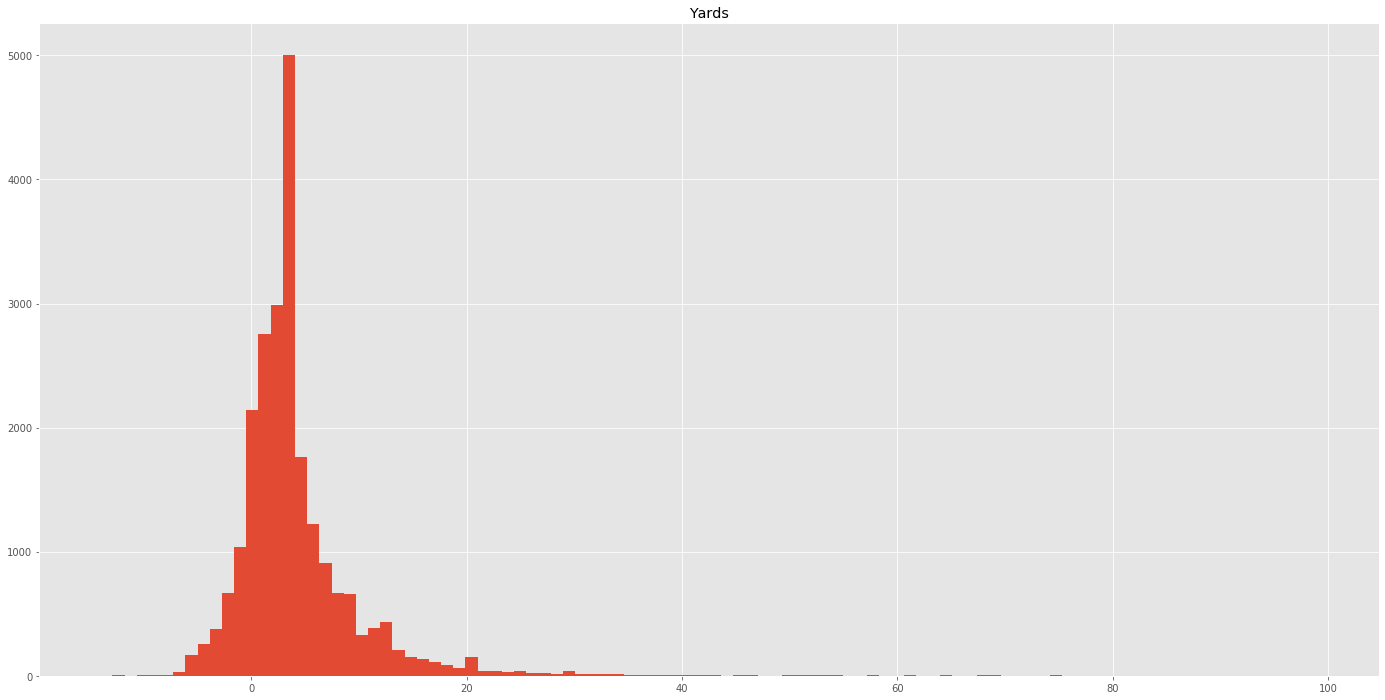

In [94]:
rushing_df.hist(column = 'Yards', bins = 100, figsize = (24,12), grid = True)

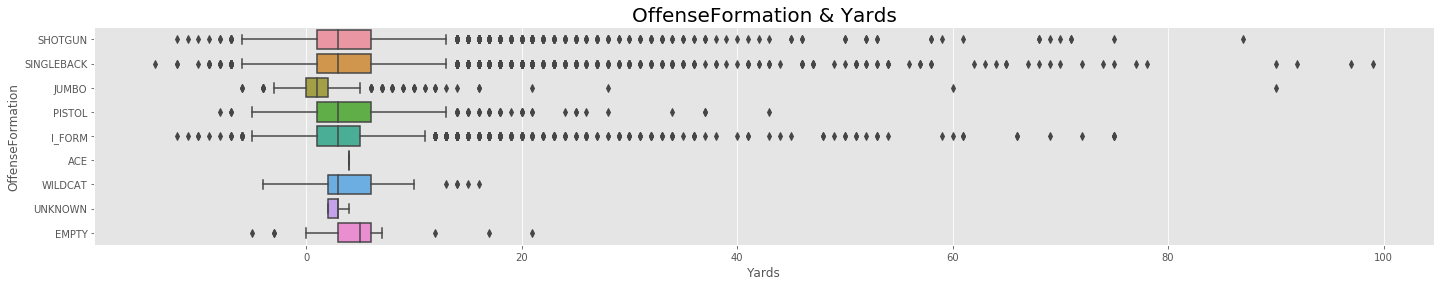

In [112]:
plt.figure(figsize=(24,4))
sns.boxplot(data=rushing_df, x="Yards", y="OffenseFormation", showfliers=True)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('OffenseFormation', fontsize=12)
plt.title("OffenseFormation & Yards", fontsize=20)
plt.show()

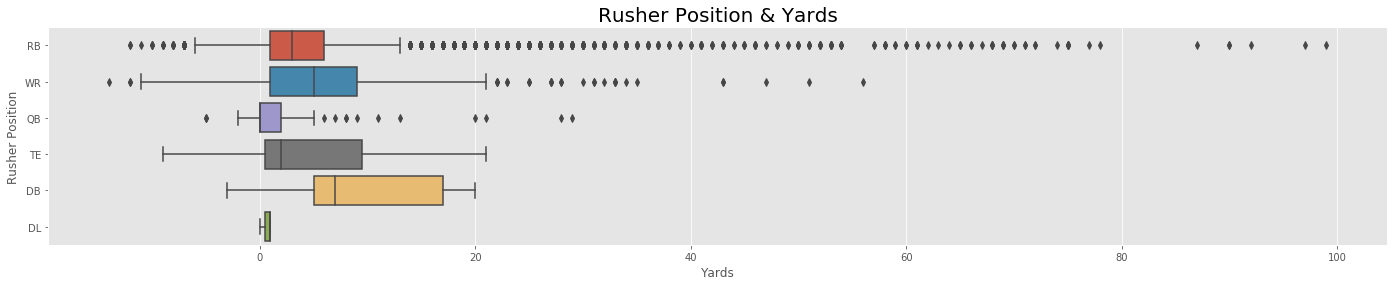

In [131]:
plt.figure(figsize=(24,4))
temp_df = train_df.query("NflIdRusher == NflId")
sns.boxplot(data=temp_df, x="Yards", y="Position", showfliers=True, order = ['RB','WR','QB','TE','DB','DL'])
plt.xlabel('Yards', fontsize=12)
plt.ylabel('Rusher Position', fontsize=12)
plt.title("Rusher Position & Yards", fontsize=20)
plt.show()

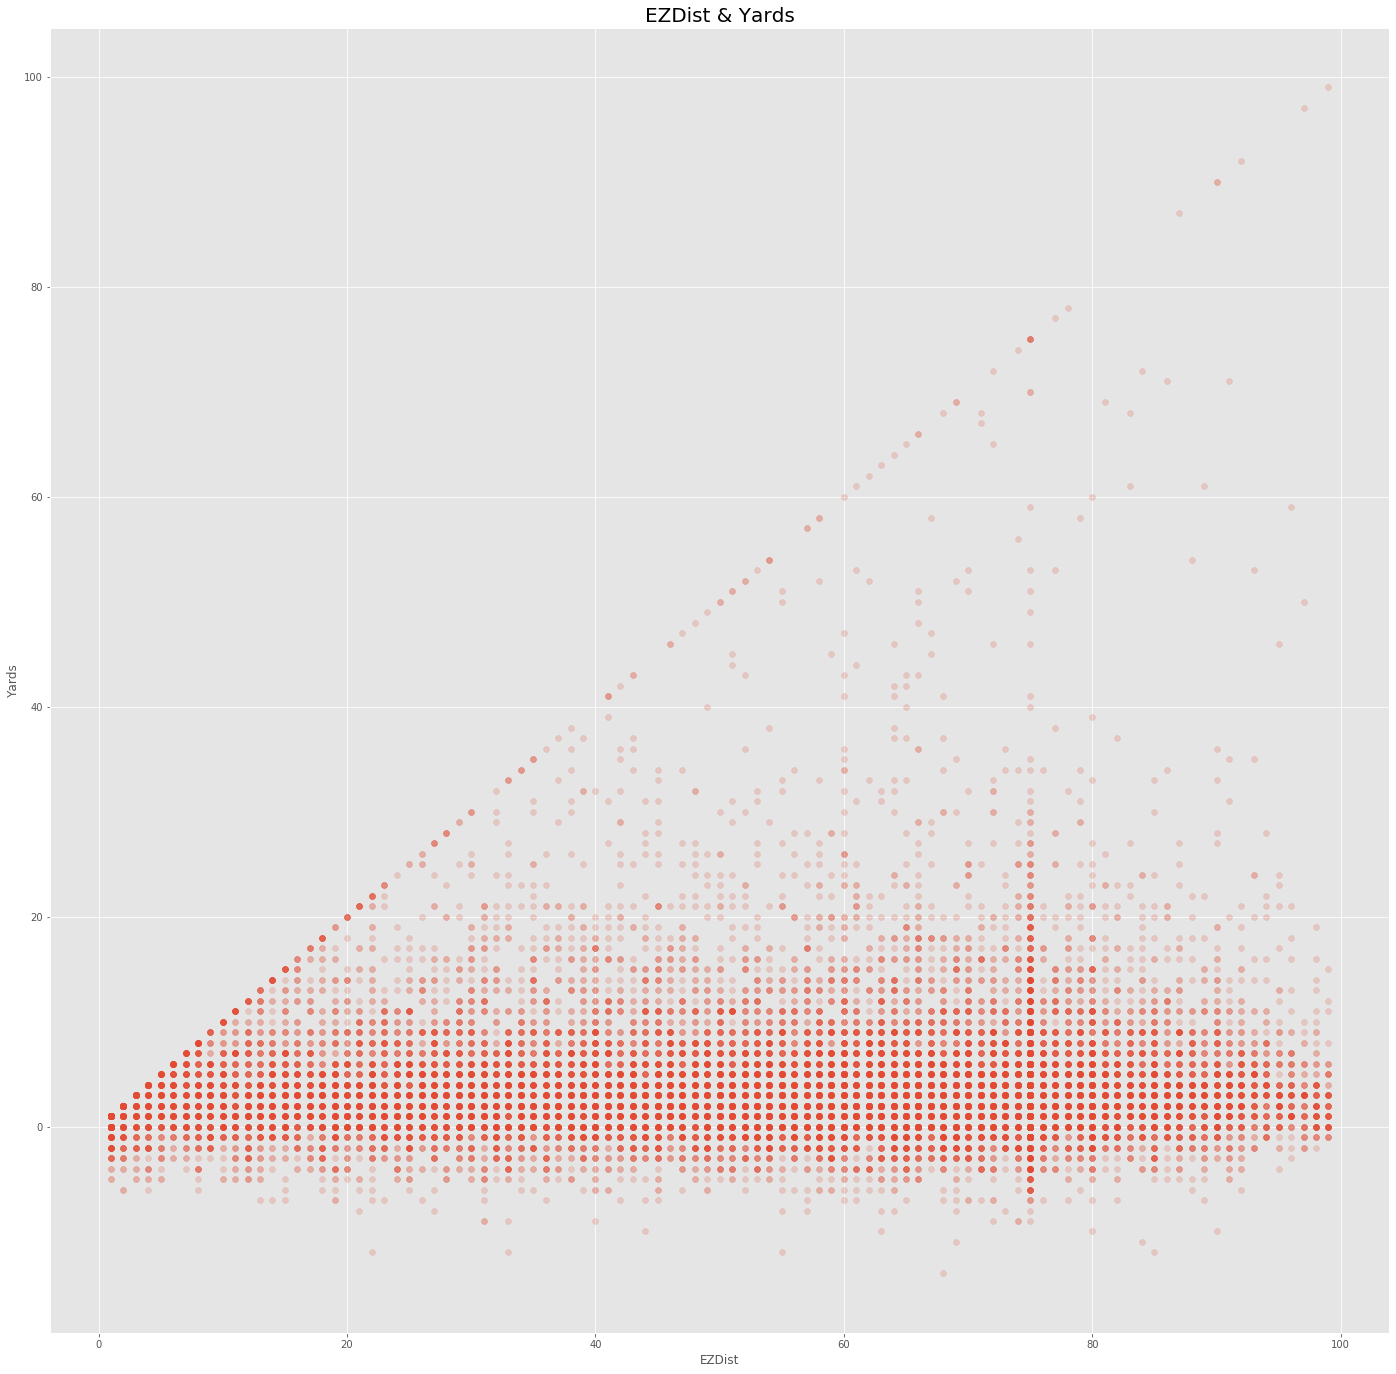

In [133]:
plt.figure(figsize=(24,24))
plt.scatter(data=rushing_df, x="EZDist", y="Yards", alpha = 0.2)
plt.xlabel('EZDist', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("EZDist & Yards", fontsize=20)
plt.show()

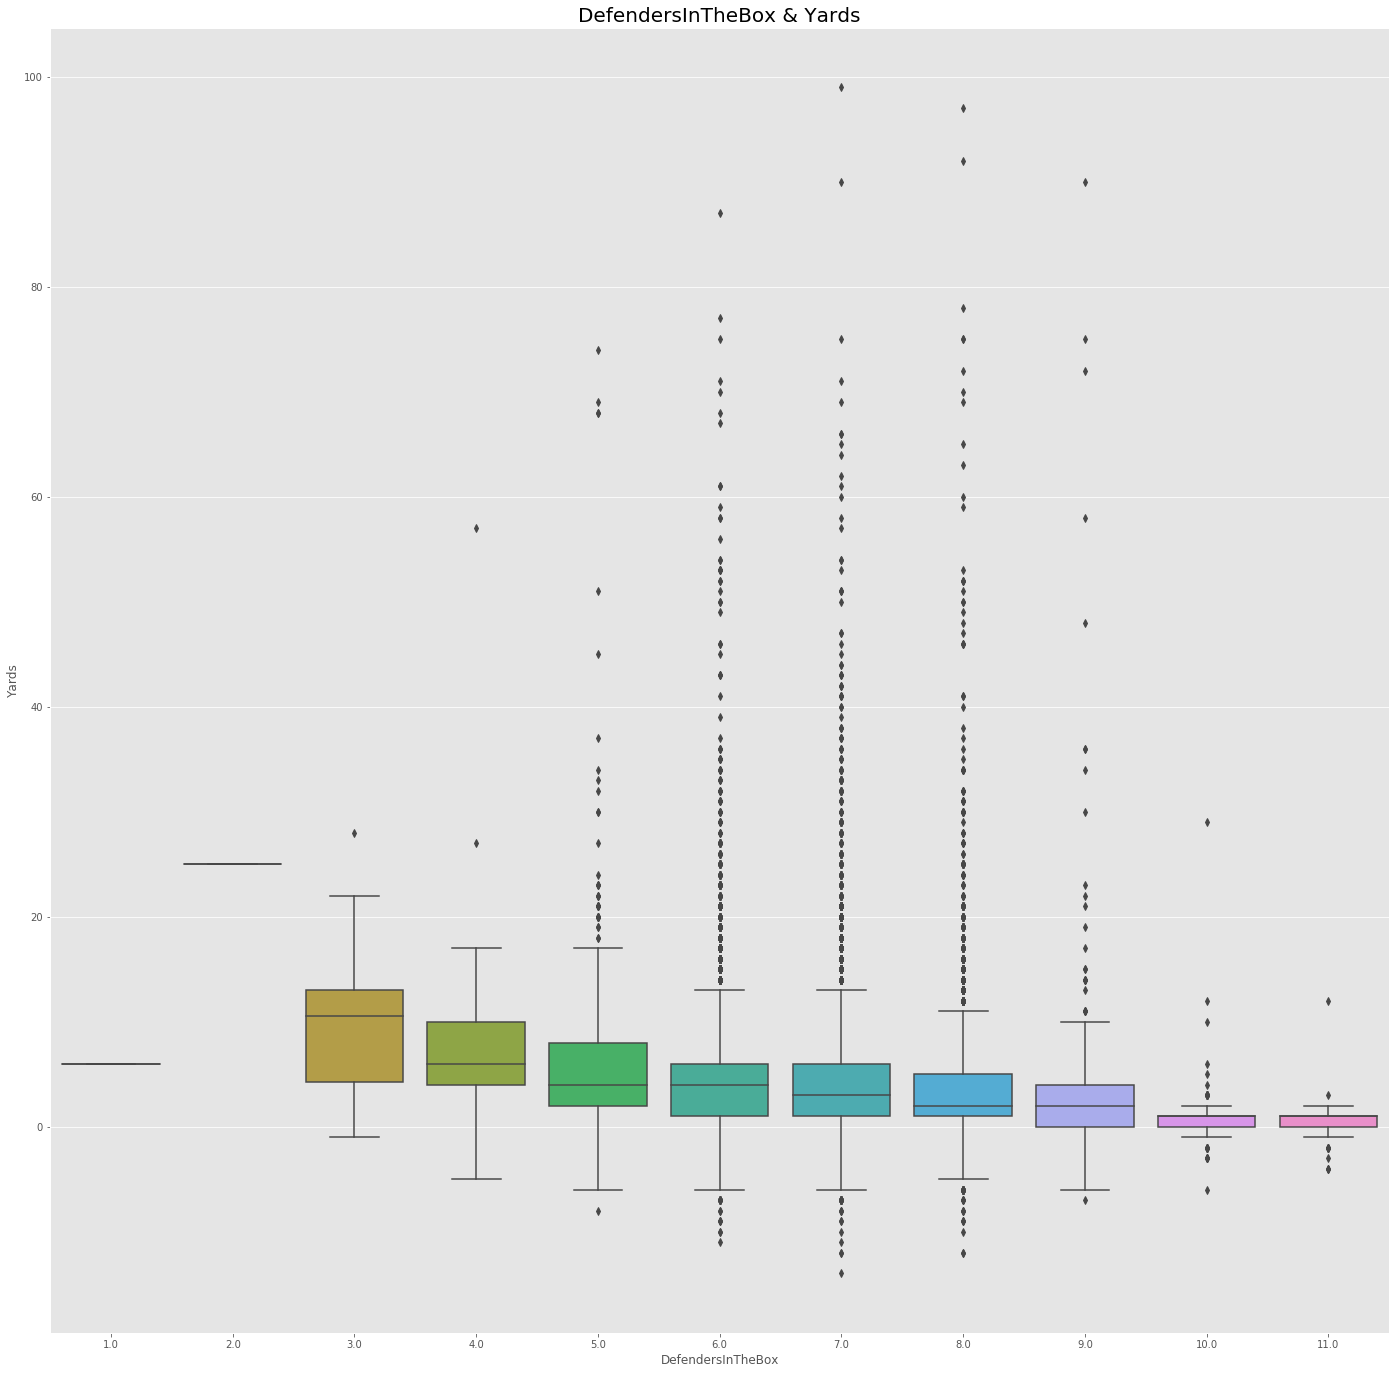

In [128]:
plt.figure(figsize=(24,24))
temp_df = train_df.query("NflIdRusher == NflId")
sns.boxplot(data=temp_df, x="DefendersInTheBox", y="Yards", showfliers=True)
plt.xlabel('DefendersInTheBox', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("DefendersInTheBox & Yards", fontsize=20)
plt.show()

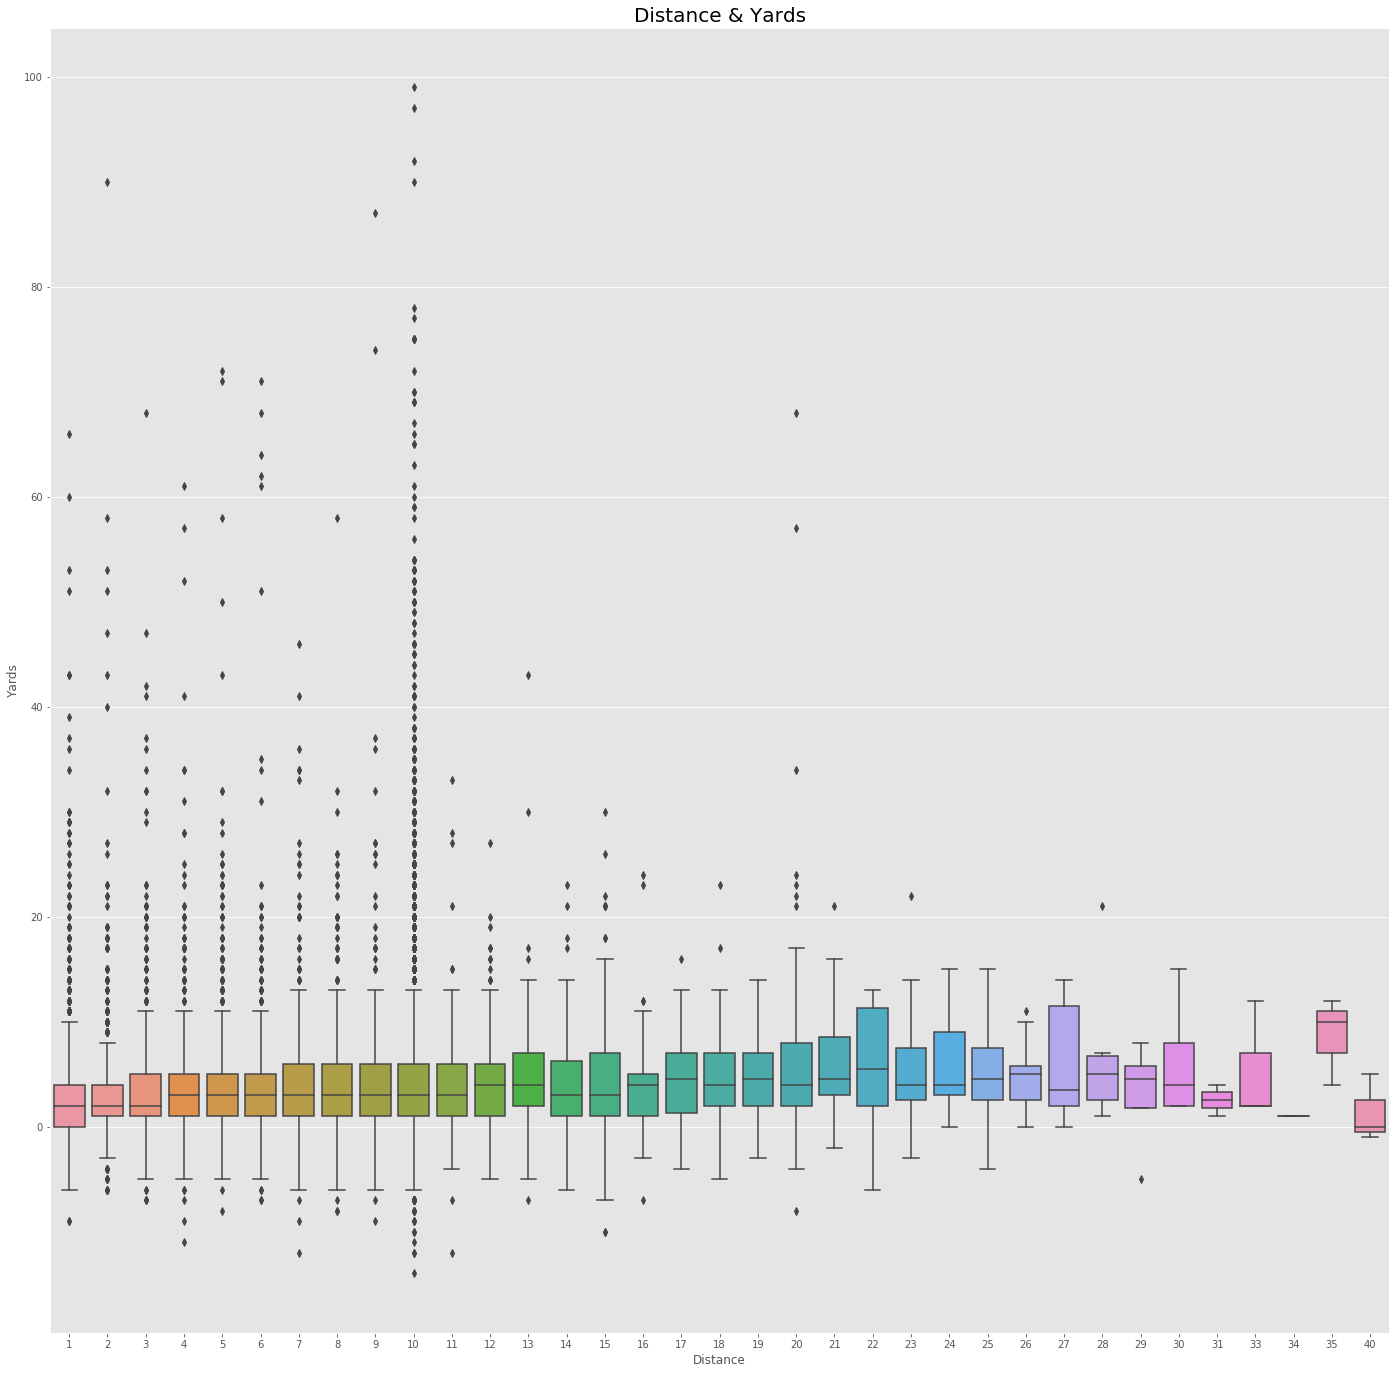

In [129]:
plt.figure(figsize=(24,24))
temp_df = train_df.query("NflIdRusher == NflId")
sns.boxplot(data=temp_df, x="Distance", y="Yards", showfliers=True)
plt.xlabel('Distance', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("Distance & Yards", fontsize=20)
plt.show()

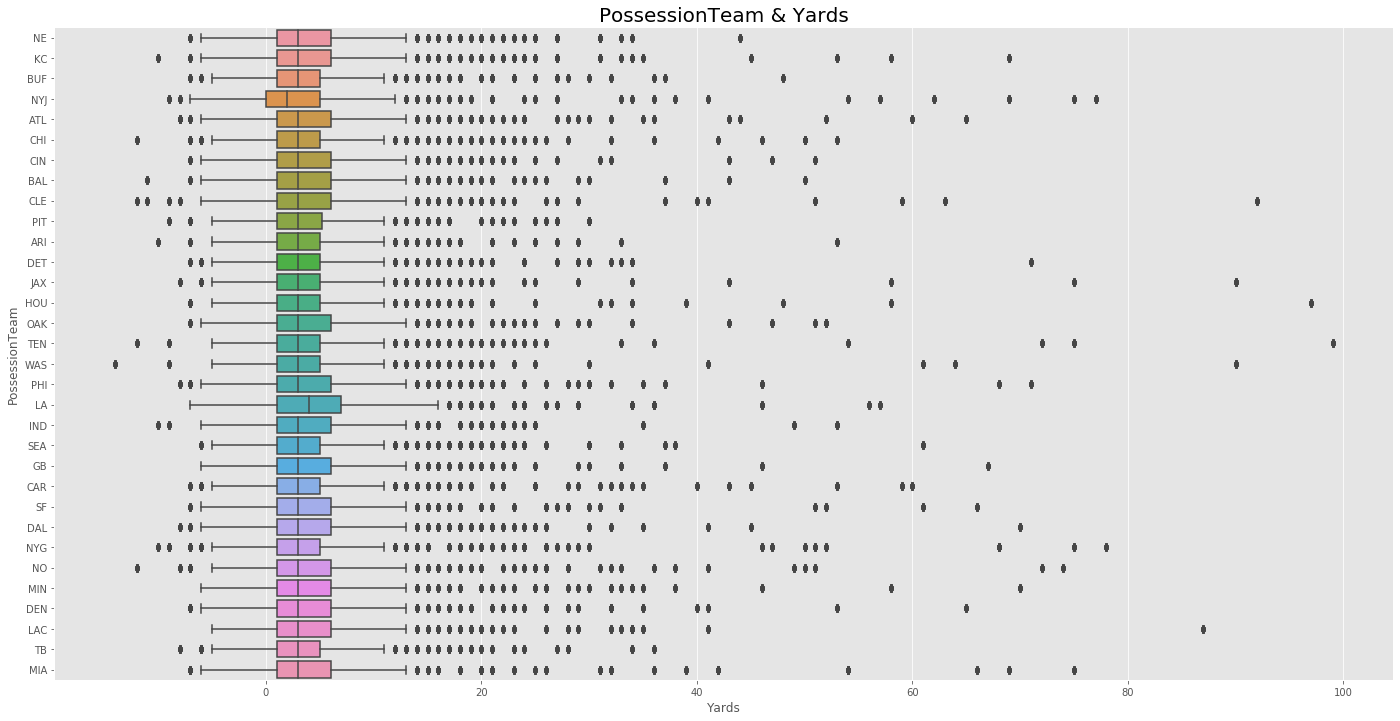

In [82]:
plt.figure(figsize=(24,12))
sns.boxplot(data=train_df, x="Yards", y="PossessionTeam", showfliers=True)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('PossessionTeam', fontsize=12)
plt.title("PossessionTeam & Yards", fontsize=20)
plt.show()

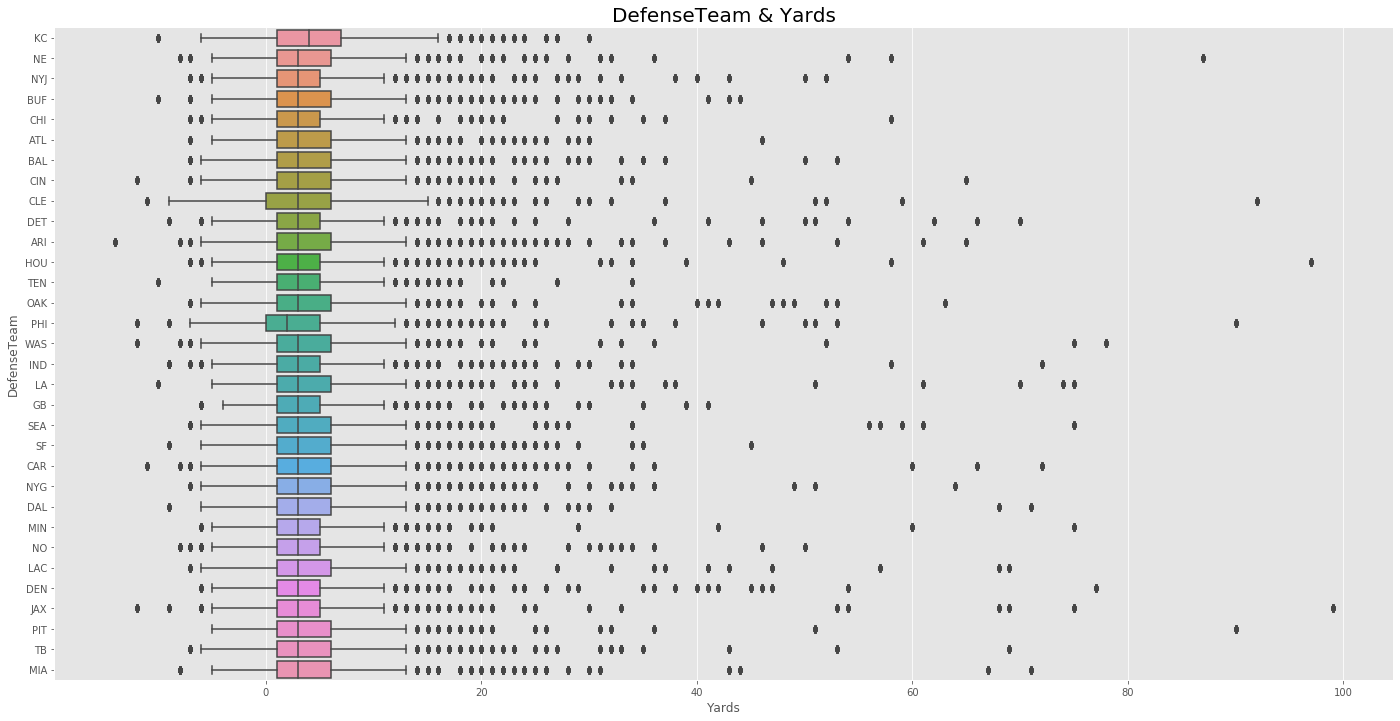

In [84]:
plt.figure(figsize=(24,12))
sns.boxplot(data=train_df, x="Yards", y="DefenseTeam", showfliers=True,)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('DefenseTeam', fontsize=12)
plt.title("DefenseTeam & Yards", fontsize=20)
plt.show()

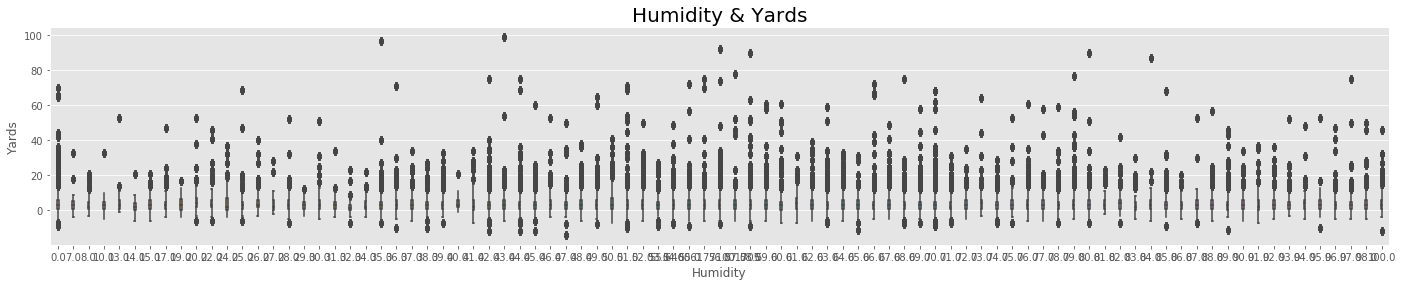

In [58]:
plt.figure(figsize=(24,4))
sns.boxplot(data=train_df, x="Humidity", y="Yards", showfliers=True, width = .1)
plt.xlabel('Humidity', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("Humidity & Yards", fontsize=20)
plt.show()

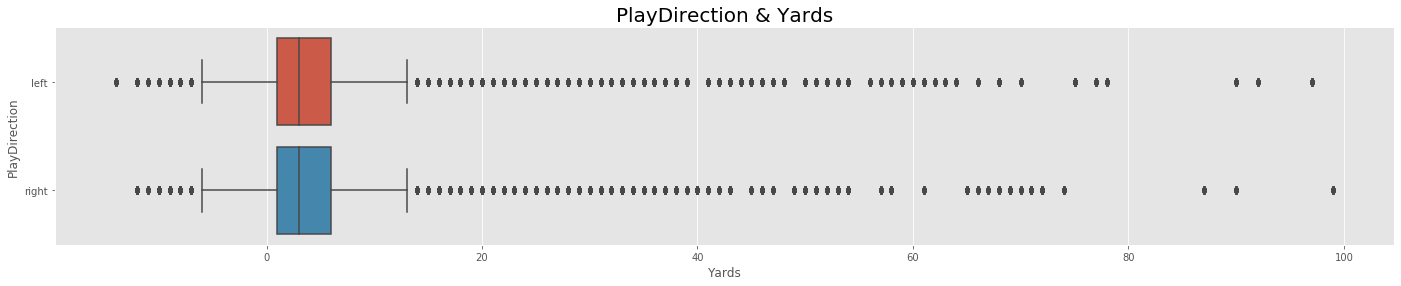

In [68]:
plt.figure(figsize=(24,4))
sns.boxplot(data=train_df, x="Yards", y="PlayDirection", showfliers=True,)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('PlayDirection', fontsize=12)
plt.title("PlayDirection & Yards", fontsize=20)
plt.show()

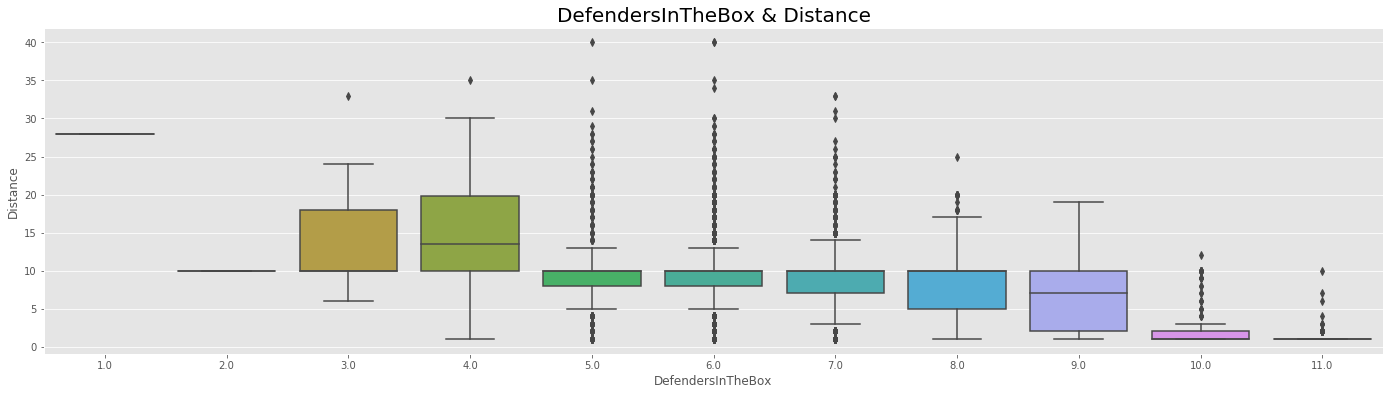

In [78]:
plt.figure(figsize=(24,6))
temp_df = train_df.query("NflIdRusher == NflId")
sns.boxplot(data=temp_df, x="DefendersInTheBox", y="Distance", showfliers=True)
plt.xlabel('DefendersInTheBox', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.title("DefendersInTheBox & Distance", fontsize=20)
plt.show()

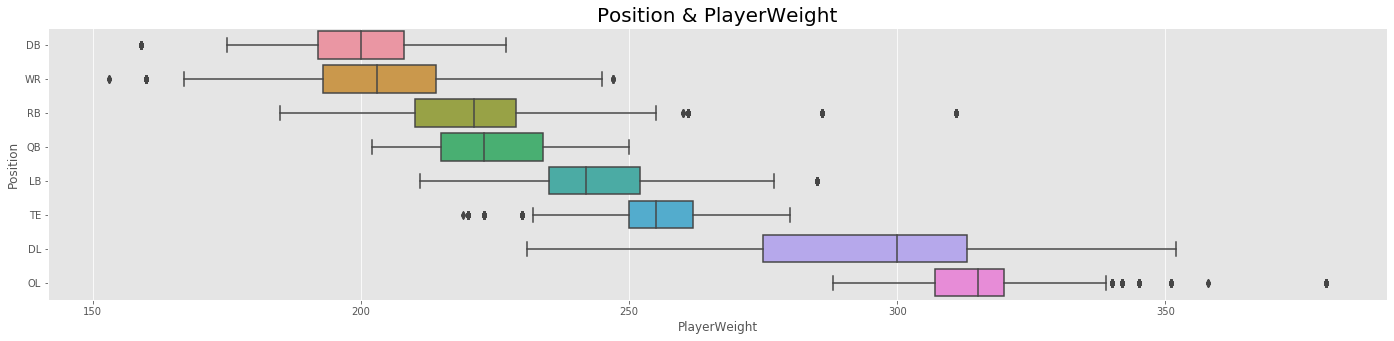

In [74]:
plt.figure(figsize=(24,5))
sns.boxplot(data=train_df, x="PlayerWeight", y="Position", showfliers=True, order = ['DB','WR','RB','QB','LB','TE','DL','OL'])
plt.xlabel('PlayerWeight', fontsize=12)
plt.ylabel('Position', fontsize=12)
plt.title("Position & PlayerWeight", fontsize=20)
plt.show()

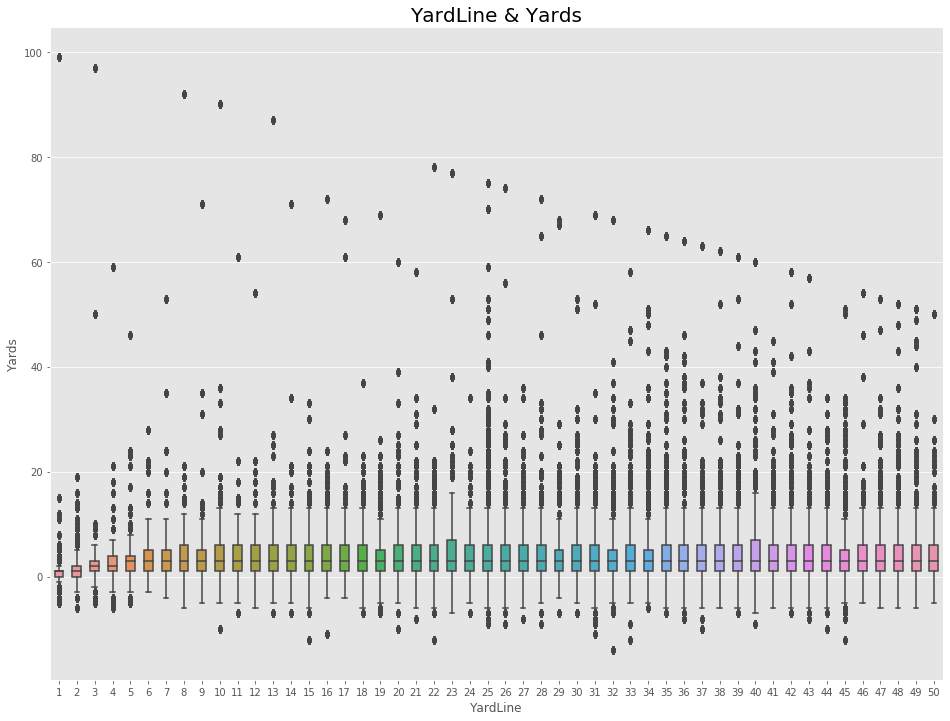

In [119]:
plt.figure(figsize=(24,12))
sns.boxplot(data=train_df, x="YardLine", y="Yards", showfliers=True, width = .5)
plt.xlabel('YardLine', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("YardLine & Yards", fontsize=20)
plt.show()

#Interesting to note linear caps on range but also seemingly as YardLine Increases so does Yards

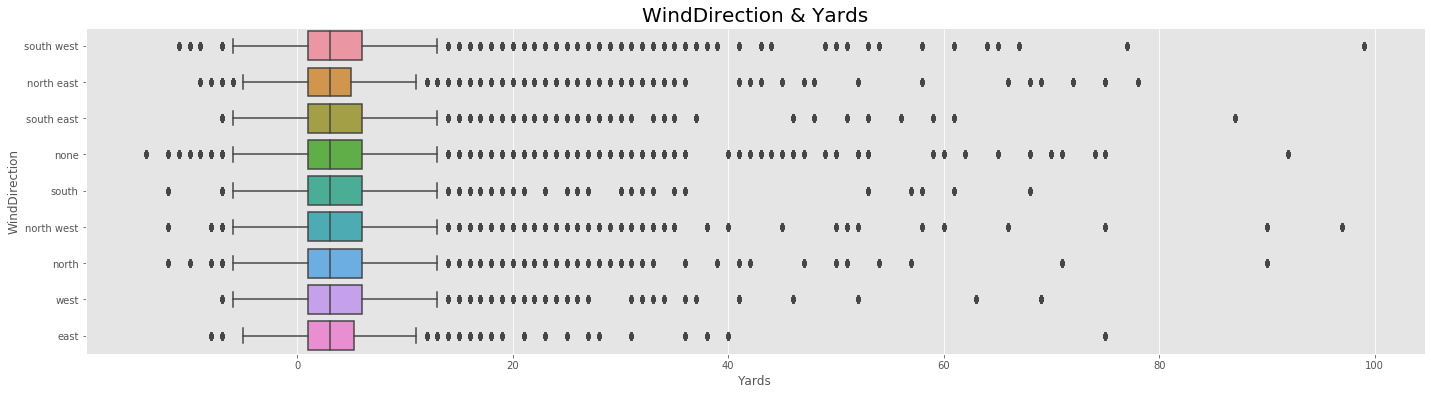

In [123]:
plt.figure(figsize=(24,6))
sns.boxplot(data=train_df, x="Yards", y="WindDirection", showfliers=True,)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('WindDirection', fontsize=12)
plt.title("WindDirection & Yards", fontsize=20)
plt.show()

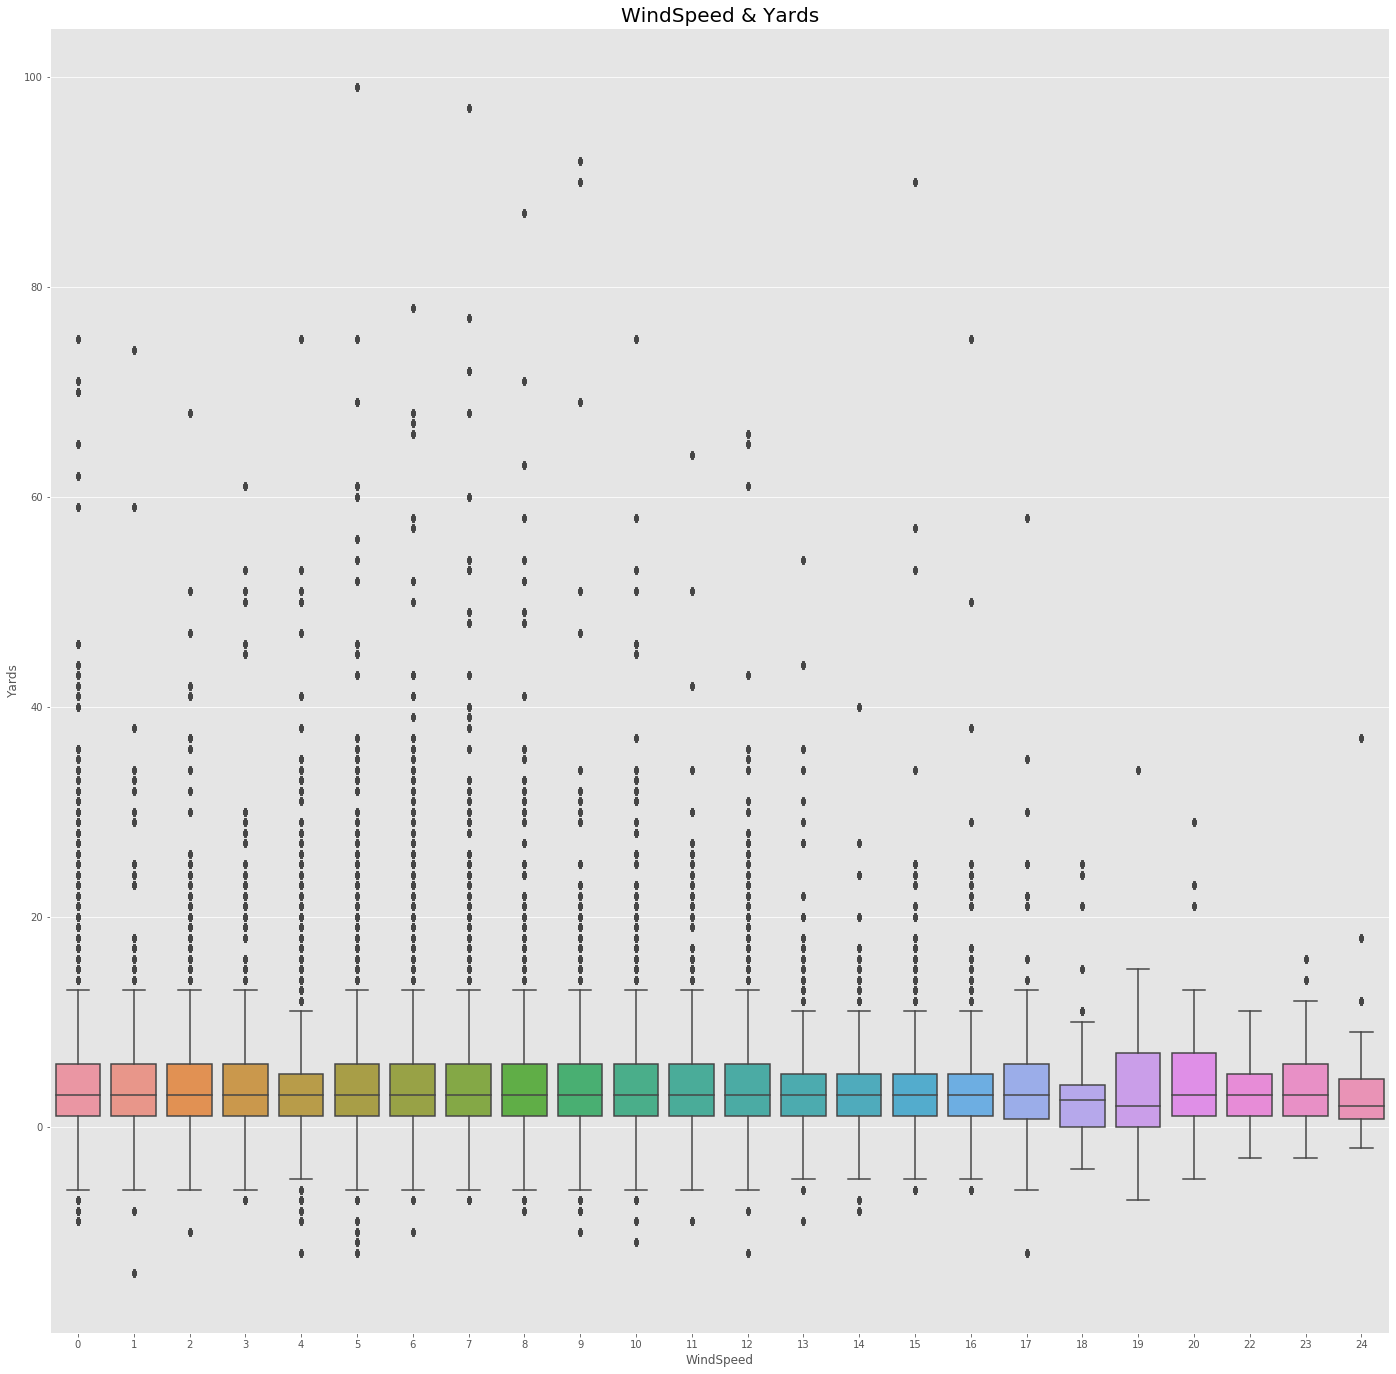

In [134]:
plt.figure(figsize=(24,24))
sns.boxplot(data=train_df, x="WindSpeed", y="Yards", showfliers=True)
plt.xlabel('WindSpeed', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("WindSpeed & Yards", fontsize=20)
plt.show()

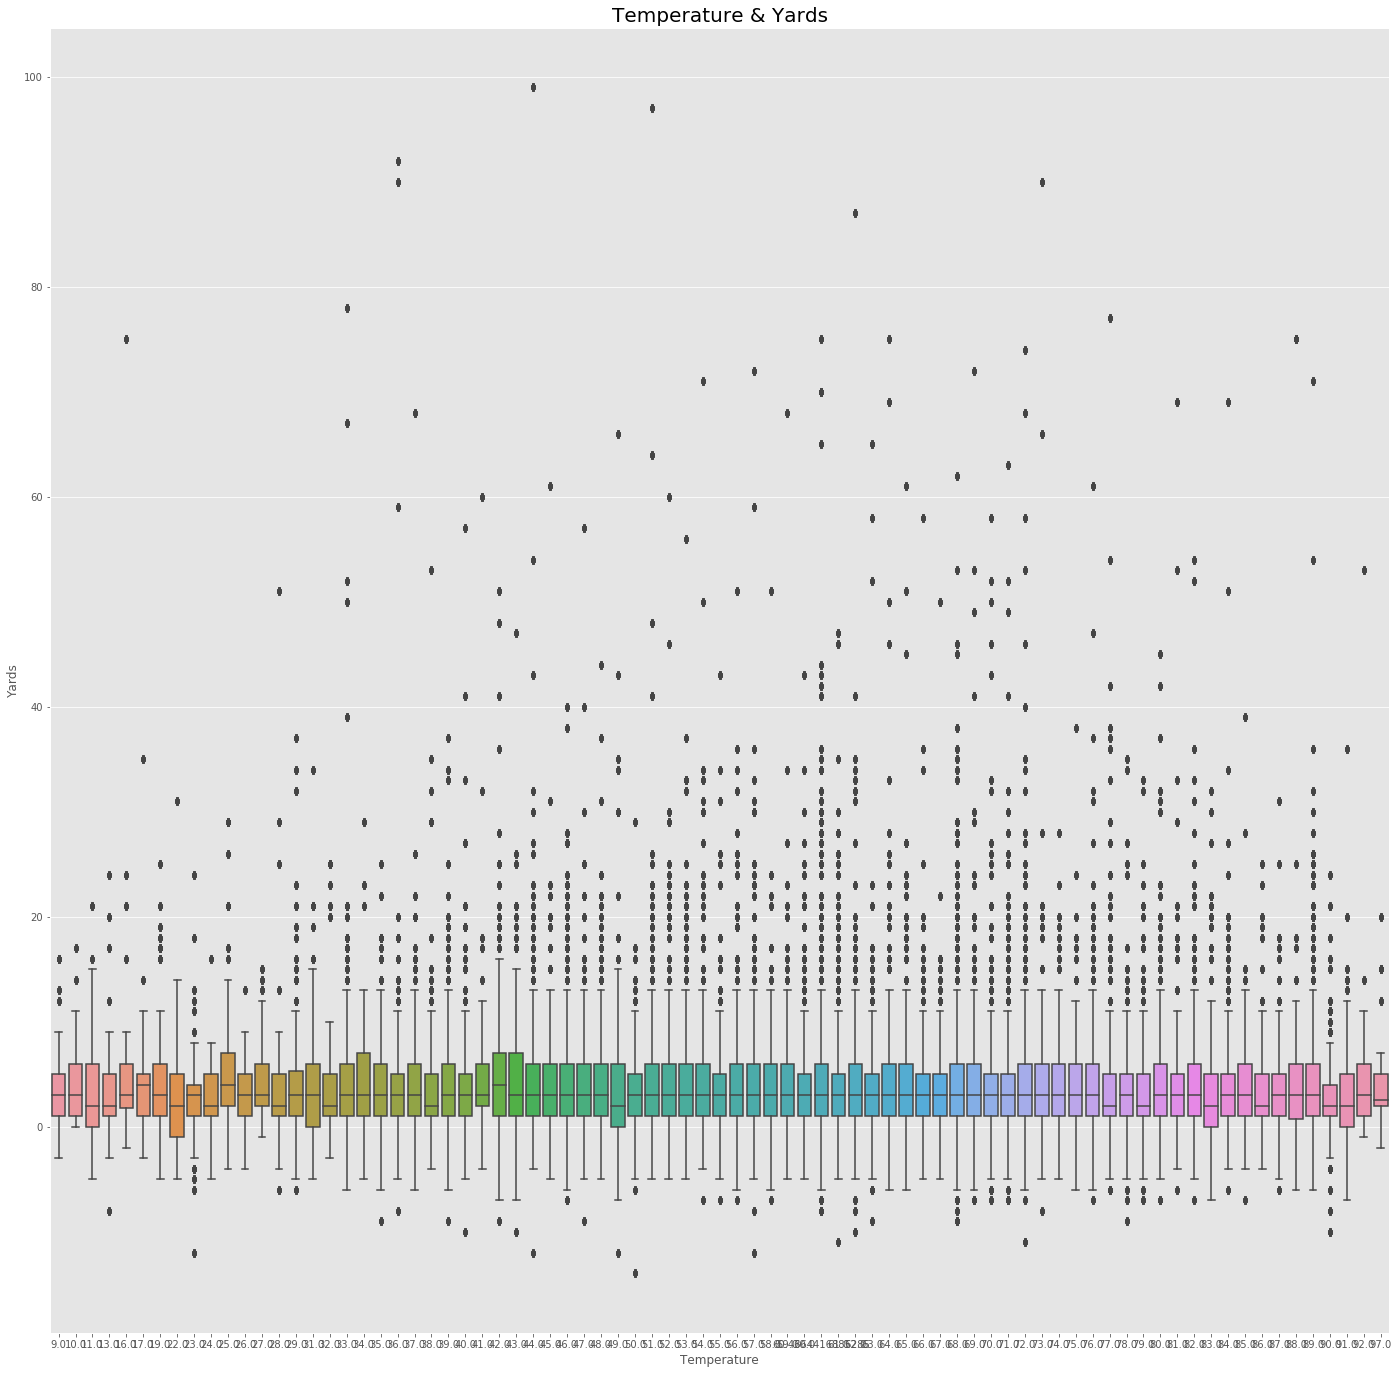

In [136]:
plt.figure(figsize=(24,24))
sns.boxplot(data=train_df, x="Temperature", y="Yards", showfliers=True)
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Yards', fontsize=12)
plt.title("Temperature & Yards", fontsize=20)
plt.show()

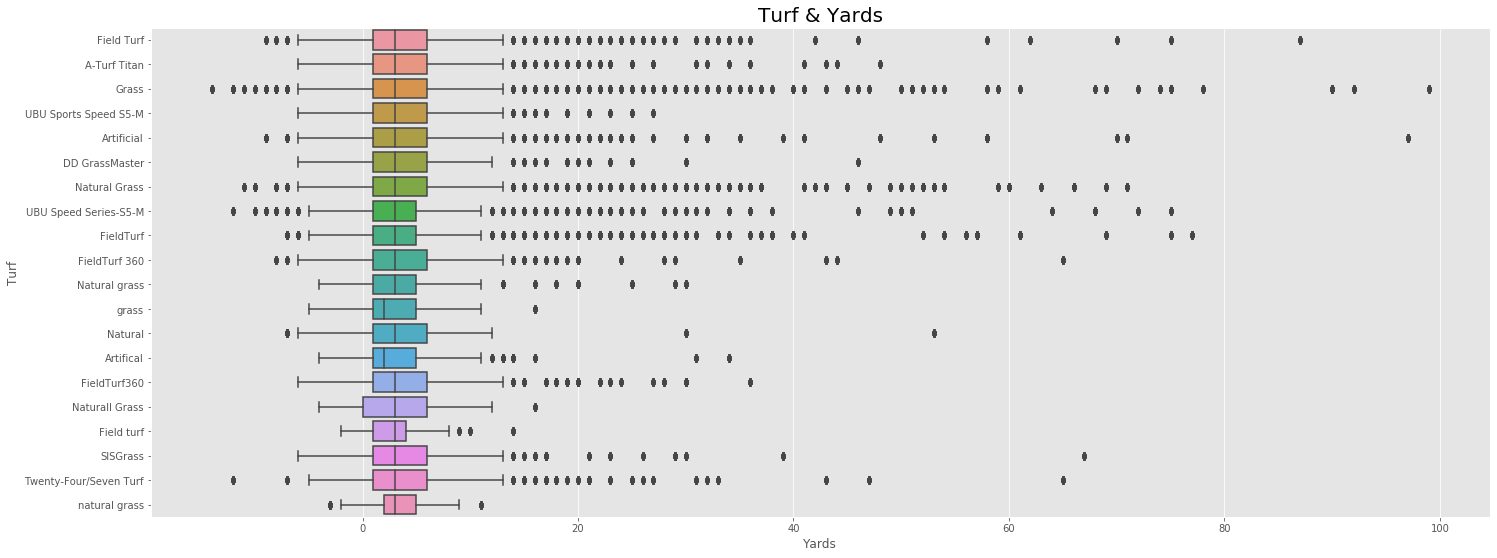

In [127]:
plt.figure(figsize=(24,9))
sns.boxplot(data=train_df, x="Yards", y="Turf", showfliers=True,)
plt.xlabel('Yards', fontsize=12)
plt.ylabel('Turf', fontsize=12)
plt.title("Turf & Yards", fontsize=20)
plt.show()